In [ ]:
!pip install --upgrade pip
!pip install "tensorflow[and-cuda]"
!pip install pandas
 

In [ ]:
!pip install scikit-learn

In [1]:
# Importa o tensorflow e verifica se a GPU está disponível
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2024-08-05 21:40:28.509451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 21:40:28.519830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 21:40:28.522997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 21:40:28.532176: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 21:40:29.118718: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1722908429.703277   36054 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722908429.718255   36054 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722908429.718418   36054 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [2]:
# Configurações
BATCH_SIZE = 32
EPOCHS = 100
IMAGE_SIZE = 64

In [3]:
import string 

# Função para remover números de uma string
def remove_numbers(s):
    return s.translate(str.maketrans('', '', string.digits))

In [4]:
from sklearn.decomposition import PCA

def apply_pca(images, n_components=10):
    flat_imgs = images.reshape(-1, images.shape[-1])
    pca = PCA(n_components=10)
    pca_imgs = pca.fit_transform(flat_imgs)
    return pca_imgs.reshape(images.shape[0], images.shape[1], images.shape[2], n_components)

In [5]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os 
from PIL import Image
import string


# Sao 31 imagens diferentes onde cada uma representa um canal de cor
def load_multispectral_imagem(image_dir):
    # Pega o diretorio de uma amostra
    file_names = sorted(os.listdir(image_dir))
    # Quantidade de graos é a quantidade de imagens dividido por 31
    qtd_graos = int(len(file_names)/31)
    print(f'Quantidade de graos: {qtd_graos}')

    multispectral_imgs = []

    # Para cada grao carrega as 31 imagens e empilha elas em um array
    for i in range(qtd_graos):
        images = [np.array(Image.open(os.path.join(image_dir, file))) for file in file_names[i*31:(i+1)*31]]
        multispectral_img = np.stack(images, axis=-1)   
        multispectral_imgs.append(multispectral_img)    
    print(multispectral_imgs[0].shape)

    pca_imgs = apply_pca(np.array(multispectral_imgs), n_components=10)
    print(pca_imgs[0].shape)
    return pca_imgs

In [6]:
# Função para carregar as imagens
def process_path(image_dir, label):
    # Carrega as imagens
    images = load_multispectral_imagem(image_dir)
    # Cria um array de labels
    labels = [label]*len(images)
    # Retorna as imagens e os labels em um dataset do tensorflow
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    # Converte as imagens para uint8 e os labels para int32
    # uint8 é um tipo de dado que armazena inteiros de 0 a 255
    # int32 é um tipo de dado que armazena inteiros de -2^31 a 2^31-1
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.uint8), tf.cast(y, tf.int32)))

    # Separa o dataset em batches
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [7]:
folder_to_label = {}
id_to_label = {}

# Carrega as pastas
folders = sorted(os.listdir('_recortado'))

i = -1
for folder in folders:
    # Pega as pastas das amostras remove o numero e temos um cateogria
    keys = list(map(lambda x: remove_numbers(x), folder_to_label.keys()))
    if not remove_numbers(folder) in keys:
        i += 1
        folder_to_label[folder] = i
    else:
        folder_to_label[folder] = i

for key, value in folder_to_label.items():
    id_to_label[value] = remove_numbers(key)

# No total sao 5 categorias e criamos dois objetos 
# Um que sai do id para o label e outro que sai do label para o id

print(folder_to_label)
print(id_to_label)
    
 

{'ardidos1': 0, 'ardidos2': 0, 'ardidos3': 0, 'ardidos4': 0, 'ardidos5': 0, 'bandinhas1': 1, 'bandinhas2': 1, 'bandinhas3': 1, 'bandinhas4': 1, 'bandinhas5': 1, 'chochos1': 2, 'chochos2': 2, 'chochos3': 2, 'chochos4': 2, 'chochos5': 2, 'fermentados1': 3, 'fermentados2': 3, 'fermentados3': 3, 'fermentados4': 3, 'fermentados5': 3, 'imaturos1': 4, 'imaturos2': 4, 'imaturos3': 4, 'imaturos4': 4, 'imaturos5': 4, 'mofados1': 5, 'mofados2': 5, 'mofados3': 5, 'mofados4': 5, 'mofados5': 5, 'purpuras1': 6, 'purpuras2': 6, 'purpuras3': 6, 'purpuras4': 6, 'purpuras5': 6, 'queimados1': 7, 'queimados2': 7, 'queimados3': 7, 'queimados4': 7, 'queimados5': 7, 'soja1': 8, 'soja2': 8, 'soja3': 8, 'soja4': 8, 'soja5': 8, 'soja_b1': 9, 'soja_b2': 9, 'soja_b3': 9, 'soja_b4': 9, 'soja_b5': 9}
{0: 'ardidos', 1: 'bandinhas', 2: 'chochos', 3: 'fermentados', 4: 'imaturos', 5: 'mofados', 6: 'purpuras', 7: 'queimados', 8: 'soja', 9: 'soja_b'}


In [8]:
# Função para criar o dataset
def create_dataset(base_dir, folder_to_label):
    all_datasets = []

    # Para cada pasta, carrega as imagens e os labels 
    # Adiciona o dataset na lista de datasets
    for folder_name, label in folder_to_label.items():
        class_dir = os.path.join(base_dir, folder_name)
        dataset = process_path(class_dir, label)
        all_datasets.append(dataset)
    
    # Mescla todos os datasets em um único dataset
    dataset = all_datasets[0]
    for ds in all_datasets[1:]:
        dataset = dataset.concatenate(ds)

    return dataset

# Chama a função para criar o dataset
dataset = create_dataset('_recortado', folder_to_label=folder_to_label)

Quantidade de graos: 199
(64, 64, 31)
(64, 64, 10)


I0000 00:00:1722908440.397534   36054 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722908440.397754   36054 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722908440.397922   36054 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722908440.470070   36054 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Quantidade de graos: 158
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 170
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 172
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 156
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 158
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 145
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 160
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 160
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 217
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 88
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 116
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 88
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 107
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 129
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 92
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 112
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 115
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 142
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 113
(64, 64, 31)
(64, 64, 10)
Quantidade de graos: 62
(64, 64, 3

In [9]:
len(dataset)


205

In [10]:
# funcao que mostra todos batch de imagens do dataset
def preview_dataset(dataset):    
    batch_count = 0
    for images_batch, labels_batch in dataset:
        print(f'Batch de imagens shape: {images_batch.shape}')
        print(f'Batch de labels shape: {labels_batch.shape}')
        
        for image, label in zip(images_batch, labels_batch):
            qtd_canais = image.shape[-1]

            print(image.shape)    
            print(id_to_label[label.numpy() ])

            plt.figure(figsize=(64,64))
            for i in range(qtd_canais):
                image_to_show = image[..., i]
                plt.subplot(1,31,i+1)
                plt.imshow(image_to_show)
                plt.axis('off')
            plt.show()

#preview_dataset(dataset)

In [11]:
# Funcao para separar o dataset em treino, validacao e teste e embaralhar
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    total_size = len(ds)
    train_size = int(total_size * train_split)
    validation_size = int(total_size * val_split)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)

    val_ds = remaining_ds.take(validation_size)
    test_ds = remaining_ds.skip(validation_size)
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

print(f'Quantidade de imagens de treino: {len(train_ds)}')
print(f'Quantidade de imagens de validação: {len(val_ds)}')
print(f'Quantidade de imagens de teste: {len(test_ds)}')

# Cache: Mantém as imagens na memória após serem carregadas do disco
# Shuffle: Mistura as imagens de treino
# Prefetch: Carrega as imagens para a GPU enquanto a GPU está ocupada
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Quantidade de imagens de treino: 164
Quantidade de imagens de validação: 20
Quantidade de imagens de teste: 21


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 10), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
# altera o tamanho da imagem e normaliza os valores
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

# aumenta a quantidade de imagens no dataset atraves de flip e rotacao
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),   
    layers.RandomRotation(0.2),
])

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 31) 
n_classes = len(id_to_label)
print(n_classes)


10


In [14]:
# visualizacao dos tensores
for data, label in train_ds.take(10):
    print(data.shape, label)

(32, 64, 64, 10) tf.Tensor([4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4], shape=(32,), dtype=int32)
(31, 64, 64, 10) tf.Tensor([8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8], shape=(31,), dtype=int32)
(32, 64, 64, 10) tf.Tensor([9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9], shape=(32,), dtype=int32)
(32, 64, 64, 10) tf.Tensor([3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3], shape=(32,), dtype=int32)
(31, 64, 64, 10) tf.Tensor([6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6], shape=(31,), dtype=int32)
(32, 64, 64, 10) tf.Tensor([2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2], shape=(32,), dtype=int32)
(32, 64, 64, 10) tf.Tensor([7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7], shape=(32,), dtype=int32)
(31, 64, 64, 10) tf.Tensor([6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6], shape=(31,), dtype=int32)
(32, 64, 64, 10) tf.Tensor([0 0 0 0 0 0 0 0 0 

2024-08-05 21:41:38.979632: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   
LAYER_SIZE = 10 
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, LAYER_SIZE)

# Cria o modelo de rede neural convolucional
# Aplicando camadas de convolução, pooling e densas
# Densas são camadas totalmente conectadas
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')  # Camada de saída com softmax para n classes
])


# Compila o modelo aplicando a função de otimização, função de perda e métricas
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Função de perda para classificação multiclasse
              metrics=['accuracy'])


# model.summary()

# Treina o modelo
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100


/home/duardo/Projects/cellpose/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-05 21:41:47.987345: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
W0000 00:00:1722908508.040974   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.061048   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.061916   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.065945   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.066859   

  1/164 ━━━━━━━━━━━━━━━━━━━━ 6:27 2s/step - accuracy: 0.0000e+00 - loss: 2.3337

W0000 00:00:1722908508.614149   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.615065   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.616951   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.618096   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.618947   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.619744   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.620620   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.622423   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.623855   36225 gp

  3/164 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.0000e+00 - loss: 2.4258

W0000 00:00:1722908508.815552   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.817718   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.818920   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.819841   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.820976   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.823073   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.824787   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.825925   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908508.826972   36225 gp

 12/164 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.0699 - loss: 2.4147      

W0000 00:00:1722908509.219835   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.224409   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.261735   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.262672   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.263592   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.265486   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.266865   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.267738   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.268548   36223 gp

 17/164 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.0807 - loss: 2.4214

W0000 00:00:1722908509.421486   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.428692   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.429770   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.430672   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.431647   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.432555   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.433638   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.435377   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.436658   36227 gp

 20/164 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.0811 - loss: 2.4233

W0000 00:00:1722908509.830399   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.831950   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.832980   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.835013   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.836450   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.837904   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.839042   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.841507   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908509.843333   36225 gp

 21/164 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.0808 - loss: 2.4234

W0000 00:00:1722908510.031598   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.032489   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.033638   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.035489   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.036474   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.037455   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.038342   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.039248   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.041184   36225 gp

 32/164 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.0862 - loss: 2.4143 

W0000 00:00:1722908510.435539   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.437325   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.438999   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.442256   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.494003   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.495279   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.496462   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.497356   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.498273   36227 gp

 41/164 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.0956 - loss: 2.4041

W0000 00:00:1722908510.638042   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.639086   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.641093   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.642210   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.648822   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.649857   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.650805   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.651873   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908510.654207   36227 gp

 44/164 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.0974 - loss: 2.4010

W0000 00:00:1722908511.040783   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.042199   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.043343   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.044316   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.045355   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.047357   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.048851   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.050236   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.051336   36224 gp

 56/164 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.0996 - loss: 2.3902

W0000 00:00:1722908511.242202   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.243110   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.244002   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.244787   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.258576   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.260159   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.260951   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.261864   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.262754   36223 gp

 58/164 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.1007 - loss: 2.3885

W0000 00:00:1722908511.654168   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.655075   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.655882   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.656692   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.657730   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.659919   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.661079   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.662026   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.662924   36225 gp

 64/164 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.1027 - loss: 2.3836

W0000 00:00:1722908511.855644   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.856485   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.857347   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.859006   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.860986   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.861903   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.862831   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.863898   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908511.865615   36226 gp

 70/164 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.1035 - loss: 2.3792

W0000 00:00:1722908512.261507   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.262617   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.263445   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.265090   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.266532   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.267429   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.268385   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.269261   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.271048   36222 gp

 72/164 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.1036 - loss: 2.3778

W0000 00:00:1722908512.462998   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.465192   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.466679   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.467757   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.468738   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.469900   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.471731   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.473359   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.474716   36224 gp

 75/164 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.1038 - loss: 2.3756

W0000 00:00:1722908512.865625   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.867077   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.868106   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.868961   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.870609   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.872313   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.873726   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.874737   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908512.875622   36225 gp

 82/164 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.1051 - loss: 2.3706

W0000 00:00:1722908513.067676   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.068623   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.069923   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.071997   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.073483   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.074582   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.075848   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.077944   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.079855   36227 gp

106/164 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.1103 - loss: 2.3583

W0000 00:00:1722908513.384065   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.385107   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.386733   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.388021   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.388809   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.389572   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.390388   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.391893   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.393433   36222 gp

129/164 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1136 - loss: 2.3459

W0000 00:00:1722908513.585187   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.587291   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.588304   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.589166   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.590045   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.591120   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.592842   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.594385   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.595306   36223 gp

131/164 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.1138 - loss: 2.3447

W0000 00:00:1722908513.786550   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.787848   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.788683   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.789523   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.790382   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.791801   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.793429   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.794388   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908513.795255   36227 gp

136/164 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1142 - loss: 2.3419

W0000 00:00:1722908514.207723   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.208568   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.210350   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.211569   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.212809   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.213653   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.214542   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.216205   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.217658   36227 gp

138/164 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1143 - loss: 2.3408

W0000 00:00:1722908514.408554   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.409905   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.411162   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.412014   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.412825   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.413527   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.414231   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.414930   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.416454   36223 gp

144/164 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1147 - loss: 2.3373

W0000 00:00:1722908514.610311   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.611607   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.612360   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.613133   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.613914   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.614691   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.616260   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.617531   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908514.618314   36227 gp

147/164 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1148 - loss: 2.3355

W0000 00:00:1722908515.022541   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.024059   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.026011   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.029308   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.031589   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.032700   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.036939   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.041657   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.099994   36225 gp

156/164 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1151 - loss: 2.3307

W0000 00:00:1722908515.227271   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.228142   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.229420   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.230270   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.230984   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.231692   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.232414   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.233119   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908515.234651   36225 gp

164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.1154 - loss: 2.3262 - val_accuracy: 0.1949 - val_loss: 2.1062
Epoch 2/100


W0000 00:00:1722908516.538244   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908516.539227   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908516.540032   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908516.540842   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908516.541646   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908516.542633   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908516.544224   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908516.545397   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908516.546234   36223 gp

 85/164 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2097 - loss: 2.0353

W0000 00:00:1722908517.362711   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.363692   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.364558   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.365346   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.366109   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.367486   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.368806   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.369765   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.370664   36227 gp

118/164 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2128 - loss: 2.0254

W0000 00:00:1722908517.563244   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.564223   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.565101   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.566141   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.567849   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.569311   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.570287   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.571210   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908517.572349   36227 gp

154/164 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2243 - loss: 2.0122

W0000 00:00:1722908518.458698   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.459788   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.460650   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.461429   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.462273   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.463046   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.464534   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.466064   36225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.466945   36225 gp

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2280 - loss: 2.0086 - val_accuracy: 0.2508 - val_loss: 1.9519
Epoch 3/100


W0000 00:00:1722908518.659344   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.660558   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.676844   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.677876   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.678993   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.679817   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.680775   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.681778   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908518.683583   36219 gp

 38/164 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3171 - loss: 1.8088   

W0000 00:00:1722908519.218658   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.219500   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.220215   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.220918   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.222427   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.223759   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.224577   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.225324   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.226036   36221 gp

 78/164 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3348 - loss: 1.7759

W0000 00:00:1722908519.420599   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.422078   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.423747   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.424828   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.425744   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.426685   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.428596   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.430128   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908519.431303   36221 gp

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3545 - loss: 1.7379 - val_accuracy: 0.3685 - val_loss: 1.5975
Epoch 4/100


W0000 00:00:1722908520.314974   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908520.315872   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908520.316799   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908520.317599   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908520.319349   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908520.320831   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908520.322118   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908520.323122   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908520.324139   36224 gp

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4032 - loss: 1.6223 - val_accuracy: 0.4973 - val_loss: 1.4000
Epoch 5/100


W0000 00:00:1722908521.708043   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908521.708873   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908521.709616   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908521.710373   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908521.711121   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908521.712034   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908521.713411   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908521.714619   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908521.715339   36222 gp

154/164 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4762 - loss: 1.5044

W0000 00:00:1722908523.043127   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.043958   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.044726   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.046051   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.047197   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.048346   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.049234   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.050019   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.050754   36226 gp

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4766 - loss: 1.4986 - val_accuracy: 0.2636 - val_loss: 1.7304
Epoch 6/100


W0000 00:00:1722908523.244270   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.245299   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.246769   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.248479   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.249591   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.250736   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.252527   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.254558   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908523.255818   36227 gp

155/164 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5373 - loss: 1.2151

W0000 00:00:1722908524.661607   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908524.662539   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908524.663714   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908524.665319   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908524.666842   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908524.667718   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908524.668794   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908524.670502   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908524.672112   36223 gp

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5386 - loss: 1.2146 - val_accuracy: 0.5505 - val_loss: 1.3113
Epoch 7/100


W0000 00:00:1722908524.862192   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908524.862986   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908524.864459   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6443 - loss: 0.9698 - val_accuracy: 0.7607 - val_loss: 0.7027
Epoch 8/100


W0000 00:00:1722908526.228389   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908526.229526   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908526.230518   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908526.231355   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908526.232324   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908526.233331   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908526.235151   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908526.236623   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908526.237503   36227 gp

154/164 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6912 - loss: 0.8423

W0000 00:00:1722908527.646983   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.647892   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.648805   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.649611   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.650505   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.651478   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.653045   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.654550   36223 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.655979   36223 gp

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6893 - loss: 0.8463 - val_accuracy: 0.6897 - val_loss: 0.8771
Epoch 9/100


W0000 00:00:1722908527.848503   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.849336   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.850201   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.851254   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.864836   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.865954   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.866951   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.867786   36227 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908527.868726   36227 gp

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6703 - loss: 0.8817 - val_accuracy: 0.7400 - val_loss: 0.7558
Epoch 10/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7128 - loss: 0.7414 - val_accuracy: 0.6171 - val_loss: 0.9595
Epoch 11/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7343 - loss: 0.6951 - val_accuracy: 0.7167 - val_loss: 0.6535
Epoch 12/100


W0000 00:00:1722908532.029183   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908532.030069   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908532.030933   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908532.031721   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908532.032574   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908532.033936   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908532.035206   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908532.036472   36226 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908532.037253   36226 gp

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7528 - loss: 0.6247 - val_accuracy: 0.8591 - val_loss: 0.3664
Epoch 13/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8021 - loss: 0.5133 - val_accuracy: 0.8435 - val_loss: 0.4290
Epoch 14/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8247 - loss: 0.4542 - val_accuracy: 0.8512 - val_loss: 0.3884
Epoch 15/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8566 - loss: 0.3851 - val_accuracy: 0.9123 - val_loss: 0.2746
Epoch 16/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8743 - loss: 0.3531 - val_accuracy: 0.9353 - val_loss: 0.1976
Epoch 17/100
154/164 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8988 - loss: 0.2774

W0000 00:00:1722908540.187424   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908540.188323   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908540.189222   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908540.190030   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908540.191501   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908540.192522   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908540.193981   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908540.194941   36224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908540.195739   36224 gp

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8987 - loss: 0.2779 - val_accuracy: 0.9351 - val_loss: 0.2009
Epoch 18/100


W0000 00:00:1722908540.388749   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908540.389649   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908540.391111   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908540.392271   36221 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8770 - loss: 0.3348 - val_accuracy: 0.9135 - val_loss: 0.2574
Epoch 19/100


W0000 00:00:1722908541.784041   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908541.785096   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908541.785930   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908541.787324   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908541.788253   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908541.789009   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908541.789834   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908541.791303   36222 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908541.792285   36222 gp

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8911 - loss: 0.3002 - val_accuracy: 0.9217 - val_loss: 0.2118
Epoch 20/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9087 - loss: 0.2662 - val_accuracy: 0.9827 - val_loss: 0.0927
Epoch 21/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8918 - loss: 0.3106 - val_accuracy: 0.8562 - val_loss: 0.4065
Epoch 22/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8809 - loss: 0.3148 - val_accuracy: 0.9353 - val_loss: 0.1881
Epoch 23/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9208 - loss: 0.2216 - val_accuracy: 0.9659 - val_loss: 0.1021
Epoch 24/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9147 - loss: 0.2220 - val_accuracy: 0.8740 - val_loss: 0.3474
Epoch 25/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9265 - loss: 0.2088 - val_accuracy: 0.8963 - val_loss: 0.2556
Epoch 26/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9394 - loss: 0.1788 - val_accuracy:

W0000 00:00:1722908555.615486   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908555.616363   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908555.617720   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908555.618502   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908555.619536   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908555.620490   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908555.621723   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908555.622805   36219 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722908555.623925   36219 gp

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9505 - loss: 0.1488 - val_accuracy: 0.9678 - val_loss: 0.0865
Epoch 30/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9289 - loss: 0.1880 - val_accuracy: 0.9423 - val_loss: 0.1557
Epoch 31/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9578 - loss: 0.1218 - val_accuracy: 0.9629 - val_loss: 0.1006
Epoch 32/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9533 - loss: 0.1452 - val_accuracy: 0.9799 - val_loss: 0.0536
Epoch 33/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9429 - loss: 0.1536 - val_accuracy: 0.9685 - val_loss: 0.0878
Epoch 34/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9712 - loss: 0.0807 - val_accuracy: 0.9719 - val_loss: 0.0682
Epoch 35/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9588 - loss: 0.1079 - val_accuracy: 0.9631 - val_loss: 0.0913
Epoch 36/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9709 - loss: 0.0823 - val_accuracy:

##### Recortado
Com 100 épocas: 

Epoch 100/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8871 - loss: 0.2952 - val_accuracy: 0.8411 - val_loss: 0.3538


##### Recortado_bkp

Usando 5 categorias de graos obtemos:

Epoch 50/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8190 - loss: 0.4544 - val_accuracy: 0.8936 - val_loss: 0.369

Epoch 30/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2930 - loss: 1.5547 - val_accuracy: 0.3529 - val_loss: 1.6023

Bandinhas - Fermentandos - Queimados - Soja - Mofados: 76%

Bandinhas - Fermentandos - Queimados - Soja: 87%

Bandinhas - Queimados - Soja: 96%

In [18]:
model.evaluate(test_ds)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0162  


[0.020526576787233353, 0.9938271641731262]

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8728 - loss: 0.3489  

Text(0.5, 1.0, 'training and validation accuracy')

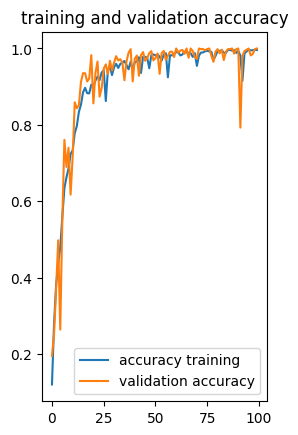

In [19]:
history.params
history.history['accuracy']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='accuracy training')
plt.plot(range(EPOCHS), val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

Text(0.5, 1.0, 'training and validation loss')

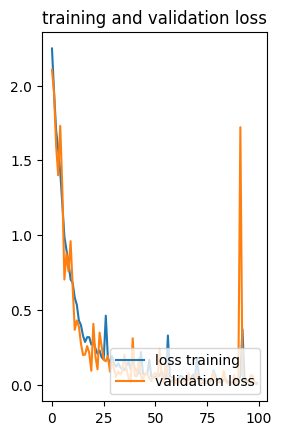

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss'] 
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='loss training')
plt.plot(range(EPOCHS), val_loss, label='validation loss')
plt.legend(loc='lower right')
plt.title('training and validation loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


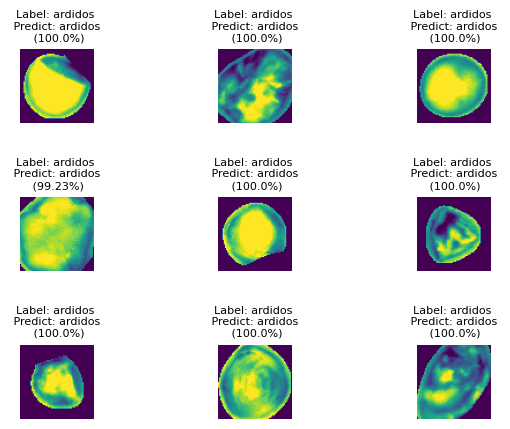

In [24]:
import tensorflow as tf


for images_batch, labels_batch in test_ds.take(1):    
    for i in range(9):
        plt.subplots_adjust(hspace=1, wspace=1)
        image = images_batch[i]
        label = labels_batch[i]
        
        im_to_show = image[...,0]
        batch_predict = model.predict(images_batch)

        best_predict = np.argmax(batch_predict[i])
        confidence = round(100 * (np.max(batch_predict[i])), 2)

        ax = plt.subplot(3,3, i+ 1)
        plt.imshow(im_to_show)
        plt.axis('off')
        plt.title(f'Label: {id_to_label[label.numpy()]} \n Predict: {id_to_label[best_predict]} \n ({confidence}%)', fontsize=8)
        
    

In [23]:
model.save(f"models/model_new{n_classes}_64.keras")